---
### Image Matching

In [1]:
# Import libraries
import cv2
import matplotlib.pyplot as plt

##### Simple Case: SIFT-Based Feature Matching

In [2]:
# Load the input images
img1 = cv2.imread(r"C:\Users\wodnj\Downloads\image1.jpg", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(r"C:\Users\wodnj\Downloads\image2.jpg", cv2.IMREAD_GRAYSCALE)

In [3]:
# Create SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors for both images
kp1_sift, des1_sift = sift.detectAndCompute(img1, None)
kp2_sift, des2_sift = sift.detectAndCompute(img2, None)

# Create a Brute-Force matcher
bf_sift = cv2.BFMatcher()

# Find the two best matches for each descriptor
matches_sift = bf_sift.knnMatch(des1_sift, des2_sift, k = 2)

In [4]:
# Apply Lowe's ratio test to select good matches
good_matches_sift = []
for m, n in matches_sift:
    if m.distance < 0.75 * n.distance:
        good_matches_sift.append(m)

print(f"Number of good matches: {len(good_matches_sift)}")

Number of good matches: 408


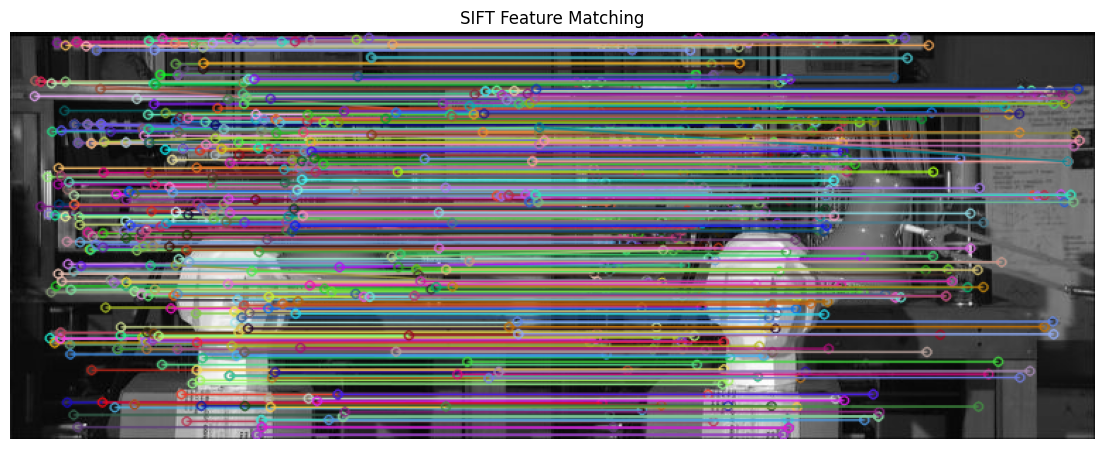

In [5]:
# Draw matches between the two images
img_matches_sift = cv2.drawMatches(img1, kp1_sift,
                                   img2, kp2_sift,
                                   good_matches_sift, None,
                                   flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matching result
plt.figure(figsize = (14, 7))
plt.imshow(img_matches_sift)
plt.title('SIFT Feature Matching')
plt.axis('off')
plt.show()

##### Simple Case: ORB-Based Feature Matching

In [6]:
# Create ORB detector
orb = cv2.ORB_create()

# Detect keypoints and compute descriptors for both images
kp1_orb, des1_orb = orb.detectAndCompute(img1, None)
kp2_orb, des2_orb = orb.detectAndCompute(img2, None)

# Create a Brute-Force matcher
bf_orb = cv2.BFMatcher(cv2.NORM_HAMMING)

# Find the two best matches for each descriptor
matches_orb = bf_orb.knnMatch(des1_orb, des2_orb, k = 2)

In [7]:
# Apply Lowe's ratio test to select good matches
good_matches_orb = []
for m, n in matches_orb:
    if m.distance < 0.75 * n.distance:
        good_matches_orb.append(m)

print(f"Number of good matches: {len(good_matches_orb)}")

Number of good matches: 231


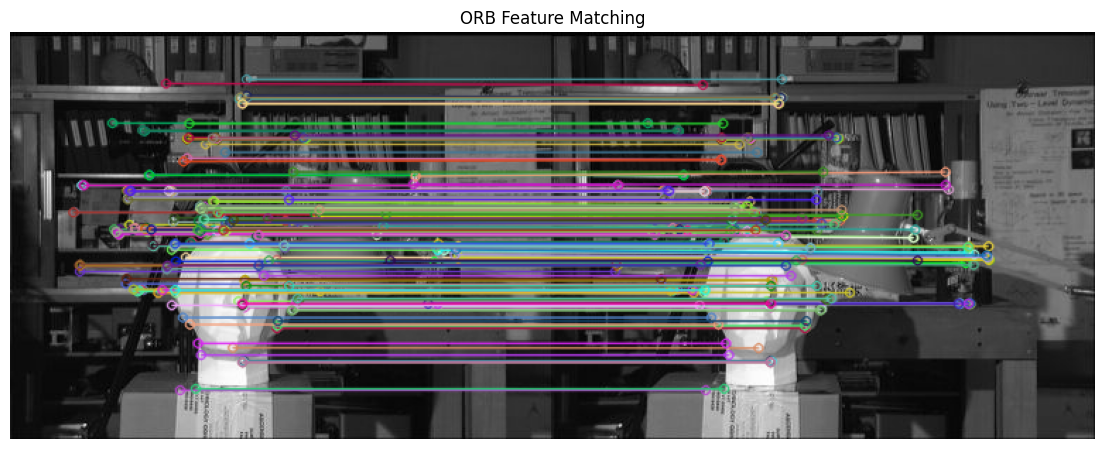

In [8]:
# Draw matches between the two images
img_matches_orb = cv2.drawMatches(img1, kp1_orb,
                                  img2, kp2_orb,
                                  good_matches_orb, None,
                                  flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matching result
plt.figure(figsize = (14, 7))
plt.imshow(img_matches_orb)
plt.title('ORB Feature Matching')
plt.axis('off')
plt.show()

##### Challenging Case: Rotated Image with SIFT

In [9]:
# Rotate image1 by 30 degrees around its center
rows, cols = img1.shape
M = cv2.getRotationMatrix2D((cols / 2, rows / 2), 30, 1) # 30-degree rotation
img1_rotated = cv2.warpAffine(img1, M, (cols, rows))

# Detect keypoints and compute descriptors for the rotated image
kp1_rot_sift, des1_rot_sift = sift.detectAndCompute(img1_rotated, None)

# Find the two best matches for each descriptor
matches_rot_sift = bf_sift.knnMatch(des1_rot_sift, des2_sift, k = 2)

In [10]:
# Apply Lowe's ratio test to select good matches
good_matches_rot_sift = []
for m, n in matches_rot_sift:
    if m.distance < 0.75 * n.distance:
        good_matches_rot_sift.append(m)

print(f"Number of good matches: {len(good_matches_rot_sift)}")

Number of good matches: 339


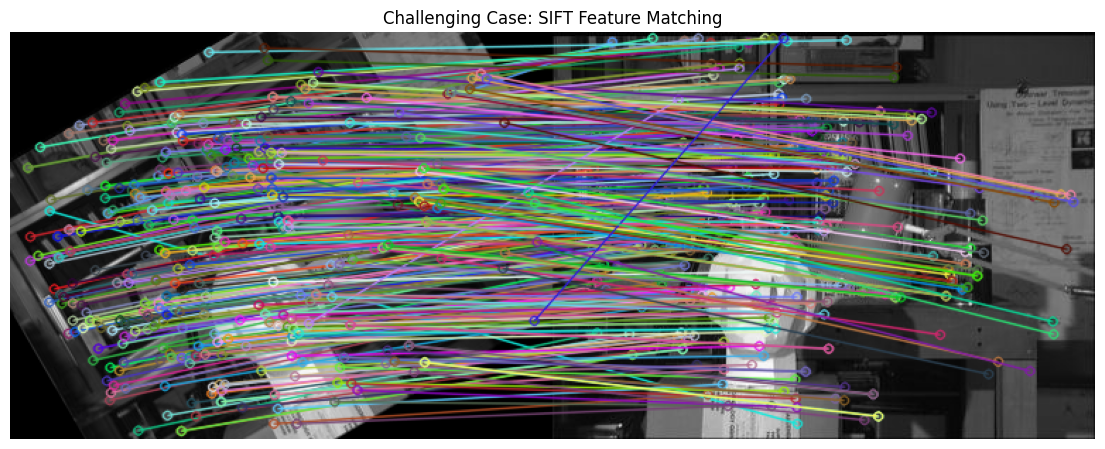

In [11]:
# Draw matches between the two images
img_matches_rot_sift = cv2.drawMatches(img1_rotated, kp1_rot_sift,
                                       img2, kp2_sift,
                                       good_matches_rot_sift, None,
                                       flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matching result
plt.figure(figsize = (14, 7))
plt.imshow(img_matches_rot_sift)
plt.title('Challenging Case: SIFT Feature Matching')
plt.axis('off')
plt.show()

In the simple case, SIFT produced 408 good matches while ORB yielded only 231 matches.<br>
This confirms that SIFT provides more robust and accurate feature detection and matching.<br> 
Even in the challenging case with image rotation, SIFT maintained 339 matches, demonstrating its rotation invariance.

---
### Fundamental Matrix

In [12]:
# Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

%matplotlib qt

##### Fundamental Matrix Estimation: Hand-chosen Points

In [13]:
# Load the images
img1 = cv2.imread(r"C:\Users\wodnj\Downloads\image1.jpg", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(r"C:\Users\wodnj\Downloads\image2.jpg", cv2.IMREAD_GRAYSCALE)

In [14]:
# Display images for manual point selection
fig, axs = plt.subplots(1, 2, figsize = (14, 7))
axs[0].imshow(img1, cmap = 'gray')
axs[0].set_title('Image 1')
axs[1].imshow(img2, cmap = 'gray')
axs[1].set_title('Image 2')
plt.tight_layout()

# Initialize point lists
pts1 = []
pts2 = []

def onclick(event):
    
    """
    Mouse click handler for selecting corresponding points from two images.

    Args:
        event: Matplotlib mouse click event
    
    Behavior:
        - Left image: Clicked points are saved to pts1 and marked in red.
        - Right image: Clicked points are saved to pts2 and marked in green.
        - When 8 points are collected from each image, interaction is disabled and the window is closed.
    """
    
    # Handle clicks in the left image
    if event.inaxes == axs[0] and len(pts1) < 8:
        pts1.append([event.xdata, event.ydata])
        axs[0].plot(event.xdata, event.ydata, 'ro')
        fig.canvas.draw()

    # Handle clicks in the right image
    elif event.inaxes == axs[1] and len(pts2) < 8:
        pts2.append([event.xdata, event.ydata])
        axs[1].plot(event.xdata, event.ydata, 'go')
        fig.canvas.draw()
    
    # Disconnect interaction once 8 points each are selected
    if len(pts1) == 8 and len(pts2) == 8:
        fig.canvas.mpl_disconnect(cid)
        plt.close()

# Connect handler and show interactive figure
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

# Block execution until all 8 points are selected
while len(pts1) < 8 or len(pts2) < 8:
    plt.pause(0.1)
    time.sleep(0.1)

In [15]:
# Convert lists to NumPy arrays
pts1 = np.array(pts1, dtype = np.float32)
pts2 = np.array(pts2, dtype = np.float32)

In [16]:
def compute_fundamental_matrix(pts1, pts2):
    
    """
    Estimate the Fundamental Matrix using the 8-point algorithm.

    Args:
        pts1: Nx2 array of points from the first image
        pts2: Nx2 array of corresponding points from the second image

    Returns:
        3x3 Fundamental Matrix with rank-2 constraint enforced
    """

    n = pts1.shape[0]
    A = np.zeros((n, 9))
    
    # Construct matrix A from point correspondences
    for i in range(n):
        x1, y1 = pts1[i]
        x2, y2 = pts2[i]
        A[i] = [x1*x2, x1*y2, x1,
                y1*x2, y1*y2, y1,
                x2,    y2,    1]
    
    # Solve Af = 0 using SVD
    _, _, Vt = np.linalg.svd(A)
    f = Vt[-1]
    F = f.reshape(3, 3)
    
    # Enforce rank-2 constraint on F
    Uf, Sf, Vtf = np.linalg.svd(F)
    Sf[-1] = 0
    F_rank2 = Uf @ np.diag(Sf) @ Vtf
    
    return F_rank2

In [17]:
# Compute Fundamental Matrix from hand-chosen points
F_hand_chosen = compute_fundamental_matrix(pts1, pts2)

##### Fundamental Matrix Estimation: Auto-Matched Points

In [18]:
# Select the best 8 matches from Problem 1
sorted_matches = sorted(good_matches_sift, key = lambda m: m.distance)
selected_matches = sorted_matches[:8]

In [19]:
# Extract corresponding point coordinates
pts1_auto = np.array([kp1_sift[m.queryIdx].pt for m in selected_matches], dtype = np.float32)
pts2_auto = np.array([kp2_sift[m.trainIdx].pt for m in selected_matches], dtype = np.float32)

In [20]:
# Compute Fundamental Matrix from auto-matched points
F_auto_matched = compute_fundamental_matrix(pts1_auto, pts2_auto)

##### Comparison of Two Fundamental Matrices

In [21]:
print(f"Hand-chosen F matrix:\n{F_hand_chosen}")
print()
print(f"Auto-matched F matrix:\n{F_auto_matched}")

Hand-chosen F matrix:
[[ 6.33416395e-06 -3.22956822e-04  4.91807735e-02]
 [ 3.42722972e-04  1.43999401e-05 -7.11782468e-02]
 [-5.49832628e-02  6.44292424e-02  9.92643138e-01]]

Auto-matched F matrix:
[[ 9.68579634e-06 -9.81740462e-04 -1.83567566e-01]
 [ 9.75844195e-04 -1.31654216e-06 -1.63360577e-01]
 [ 1.82178944e-01  1.69365084e-01  9.36878143e-01]]


The fundamental matrix derived from hand-chosen points has smaller off-diagonal values and a final entry close to 1, suggesting more stable estimation with less distortion.<br>
In contrast, the auto-matched matrix contains larger values, especially in the third row and third column. This indicates a higher level of noise or mismatched correspondences.<br> These differences show that manual correspondences produced a cleaner and more consistent result, while the automatic method may require further refinement to improve epipolar accuracy.